### This notebook will load the individual connectivty weights and analyze the `coef_` and `coef_1` and `coef_2`

In [1]:
import init_paths
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import cortico_cereb_connectivity.evaluation as ev
import Functional_Fusion.dataset as fdata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def calc_var_df(train_types):
    var_dic = {'eval_dataset': [],
               'logalpha': [],
               'eval_subj': [],
               'coef_var': [],
               'coef_norm': [],
               'sig_norm': [],
               'coef_var_g': [],
               'coef_var_s': [],
               'coef_var_m': [],
               'cosine_similarity': [],
               'correlation': [],
               'covariance': []}
    for dataset_name, (ses, la) in train_types.items():
        config = rm.get_eval_config(eval_dataset=dataset_name, eval_ses=ses, model='ind', cerebellum='MNISymC3', add_rest=True)
        dataset = fdata.get_dataset_class(gl.base_dir, dataset=dataset_name)
        config["subj_list"] = dataset.get_participants().participant_id
        S = len(config['subj_list'])

        for alpha in la:
            dirname = f"{dataset_name}_{ses}_Icosahedron1002_L2reghalf"
            mname = f"{dataset_name}_{ses}_Icosahedron1002_L2reghalf_A{alpha}"

            fm,_ = rm.get_fitted_models([dirname],[mname],config)
            fm = fm[0]

            n_vox, n_region = fm[0].coef_.shape
            coef_1 = np.stack([fm[s].coef_1 for s in range(S)], axis=0)
            coef_2 = np.stack([fm[s].coef_2 for s in range(S)], axis=0)

            vg, vs, vm = rm.decompose_variance_half(np.stack((coef_1, coef_2), axis=1))
            for s in range(S):
                coef_norm = np.linalg.norm(np.nan_to_num(fm[s].coef_))
                sig_norm2 = coef_norm**2 - n_vox*n_region*(vs[s]+vm[s]/2)
                var_dic['coef_var'].append(vs[s]+vm[s]/2)
                var_dic['coef_norm'].append(coef_norm)
                var_dic['sig_norm'].append(np.sqrt(sig_norm2))
                data = np.concatenate([fm[s].coef_1.T, fm[s].coef_2.T], axis=0)
                dataframe = pd.DataFrame({'half': np.repeat([1,2], fm[s].coef_1.shape[1])})
                R, _, _, _ = ev.calculate_reliability(data, dataframe)
                var_dic['cosine_similarity'].append(R)
                R = np.corrcoef(fm[s].coef_1.flatten(), fm[s].coef_2.flatten())[0,1]
                var_dic['correlation'].append(R)
                cov_xy = np.cov(fm[s].coef_1.flatten(), fm[s].coef_2.flatten(), ddof=0)[0, 1]
                var_dic['covariance'].append(cov_xy)
            var_dic['coef_var_g'].extend(vg)
            var_dic['coef_var_s'].extend(vs)
            var_dic['coef_var_m'].extend(vm)
            var_dic['eval_subj'].extend(config["subj_list"])
            var_dic['logalpha'].extend([alpha]*S)
        var_dic['eval_dataset'].extend([dataset_name]*(len(var_dic['eval_subj'])-len(var_dic['eval_dataset'])))

    var_df = pd.DataFrame(var_dic)
    var_df['subj_id'] = var_df['eval_subj']
    var_df['train_dataset'] = var_df['eval_dataset']
    var_df['effective_weight'] = var_df['sig_norm'] / var_df['coef_var']
    var_df['contribution'] = var_df['effective_weight'] * var_df['coef_norm']
    return var_df

In [3]:
dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto"]
logalpha = [2, 4, 6, 8, 10, 12]
train_types = {}
for d, dataset_name in enumerate(dataset_list):
    if dataset_name == 'Language':
        train_types[dataset_name] = ('ses-localizer_cond', logalpha)
    else:
        train_types[dataset_name] = ('all', logalpha)

In [4]:
var_df = calc_var_df(train_types)
var_df.to_csv('/home/UWO/ashahb7/Github/bayes_temp/decom_var_df.tsv', sep='\t', index=False)

/home/UWO/ashahb7/Github/cortico_cereb_connectivity/cortico_cereb_connectivity/run_model.py:1033: RuntimeWarning: invalid value encountered in sqrt
  vg = np.nansum(np.sqrt(SS_2[:, None] / SS_2) * SS_1, axis=1) / (n_sub-1)    # Shape: (n_sub)
/tmp/ipykernel_475344/2387817988.py:37: RuntimeWarning: invalid value encountered in sqrt
  var_dic['sig_norm'].append(np.sqrt(sig_norm2))
/home/UWO/ashahb7/Github/cortico_cereb_connectivity/cortico_cereb_connectivity/run_model.py:1033: RuntimeWarning: invalid value encountered in sqrt
  vg = np.nansum(np.sqrt(SS_2[:, None] / SS_2) * SS_1, axis=1) / (n_sub-1)    # Shape: (n_sub)
/tmp/ipykernel_475344/2387817988.py:37: RuntimeWarning: invalid value encountered in sqrt
  var_dic['sig_norm'].append(np.sqrt(sig_norm2))
/home/UWO/ashahb7/Github/cortico_cereb_connectivity/cortico_cereb_connectivity/run_model.py:1033: RuntimeWarning: invalid value encountered in sqrt
  vg = np.nansum(np.sqrt(SS_2[:, None] / SS_2) * SS_1, axis=1) / (n_sub-1)    # Shape: (

In [5]:
var_df = pd.read_csv('/home/UWO/ashahb7/Github/bayes_temp/decom_var_df.tsv', sep='\t')

### Reliability across logalpha

/tmp/ipykernel_475344/580431309.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)
/tmp/ipykernel_475344/580431309.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


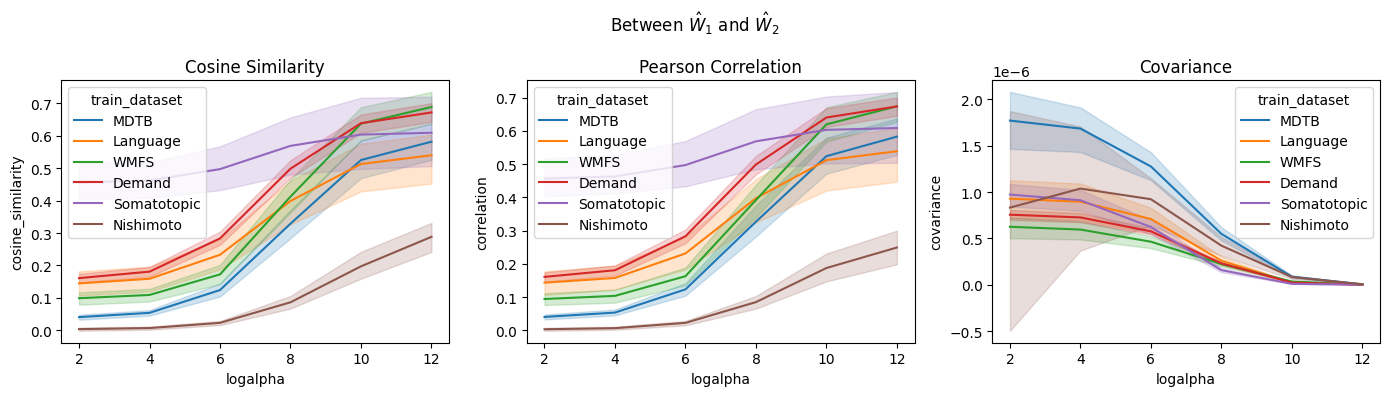

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14,4), sharey=True)
plt.suptitle(r'Between $\hat{W}_1$ and $\hat{W}_2$')

plt.subplot(1,3,1)
sns.lineplot(data=var_df, x='logalpha', y='cosine_similarity', hue='train_dataset')
plt.title('Cosine Similarity')

plt.subplot(1,3,2)
sns.lineplot(data=var_df, x='logalpha', y='correlation', hue='train_dataset')
plt.title('Pearson Correlation')

plt.subplot(1,3,3)
sns.lineplot(data=var_df, x='logalpha', y='covariance', hue='train_dataset')
plt.title('Covariance')

for ax in axes:
    ax.set_xlabel('logalpha')
    ax.set_ylabel('')
    ax.set_ylim([0, 1])
    ax.legend(title='Dataset')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout()

### Best logalpha based on reliability maximization

In [7]:
A = pd.pivot_table(var_df,index=['train_dataset'],columns=['logalpha'],values=['correlation'],aggfunc='mean').reindex(dataset_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
var_df['isbest'] = var_df.logalpha.values == bestla.loc[var_df.train_dataset].values.flatten()
best_var_df = var_df[var_df['isbest']].reset_index()

correlation                                                  
logalpha               2         4         6         8         10        12
train_dataset                                                              
MDTB             0.040558  0.053624  0.123434  0.326818  0.523760  0.582448
Language         0.143515  0.157682  0.231381  0.397342  0.511808  0.538555
WMFS             0.094498  0.103871  0.162954  0.391894  0.619388  0.673532
Demand           0.160953  0.180844  0.283063  0.498772  0.639929  0.673231
Somatotopic      0.456346  0.462812  0.496977  0.568318  0.602848  0.608337
Nishimoto        0.003597  0.006818  0.022752  0.085071  0.187576  0.249204

,best_logalpha
train_dataset,
MDTB,12
Language,12
WMFS,12
Demand,12
Somatotopic,12
Nishimoto,12


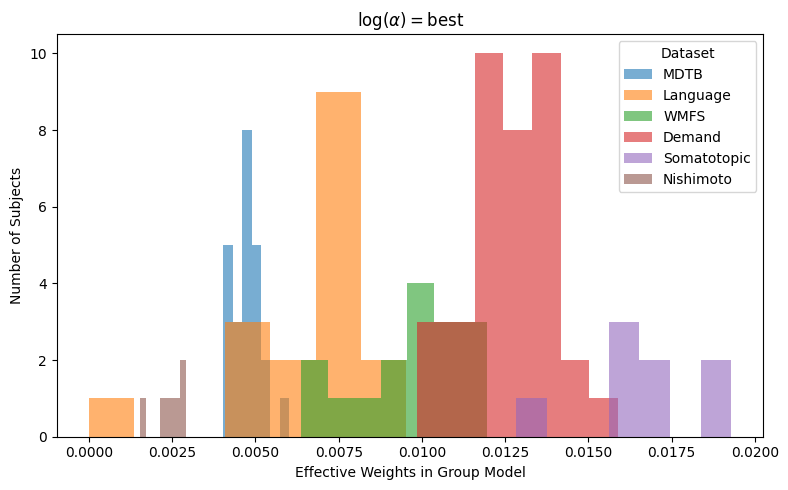

In [8]:
plt.figure(figsize=(8,5))
all_weights = np.sum(best_var_df.effective_weight)
for dataset_name in dataset_list:
    plt.hist(best_var_df[best_var_df.train_dataset == dataset_name].effective_weight / all_weights, bins=7, alpha=0.6, label=dataset_name)
plt.xlabel('Effective Weights in Group Model')
plt.ylabel('Number of Subjects')
plt.legend(title='Dataset')
plt.title(r'$\log(\alpha)=$best')
plt.tight_layout()
plt.show()

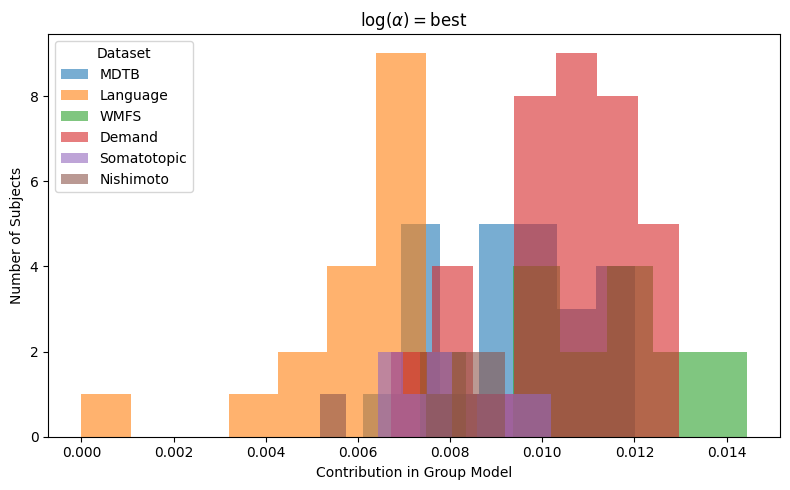

In [9]:
plt.figure(figsize=(8,5))
all_contribution = np.sum(best_var_df.contribution)
for dataset_name in dataset_list:
    plt.hist(best_var_df[best_var_df.train_dataset == dataset_name].contribution / all_contribution, bins=7, alpha=0.6, label=dataset_name)
plt.xlabel('Contribution in Group Model')
plt.ylabel('Number of Subjects')
plt.legend(title='Dataset')
plt.title(r'$\log(\alpha)=$best')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Number of Subjects from each Dataset')

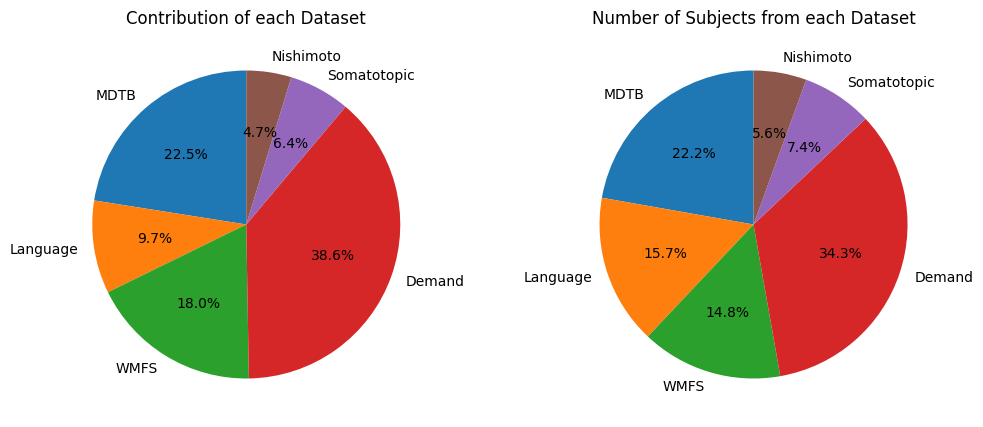

In [10]:
plt.subplots(1,2, figsize=(12,5))
plt.subplot(1,2,1)
plt.pie(best_var_df.groupby('train_dataset')['contribution'].sum().reindex(dataset_list), labels=dataset_list, autopct='%1.1f%%', startangle=90)
plt.title('Contribution of each Dataset')
plt.subplot(1,2,2)
plt.pie(best_var_df.groupby('train_dataset').size().reindex(dataset_list), labels=dataset_list, autopct='%1.1f%%', startangle=90)
plt.title('Number of Subjects from each Dataset')

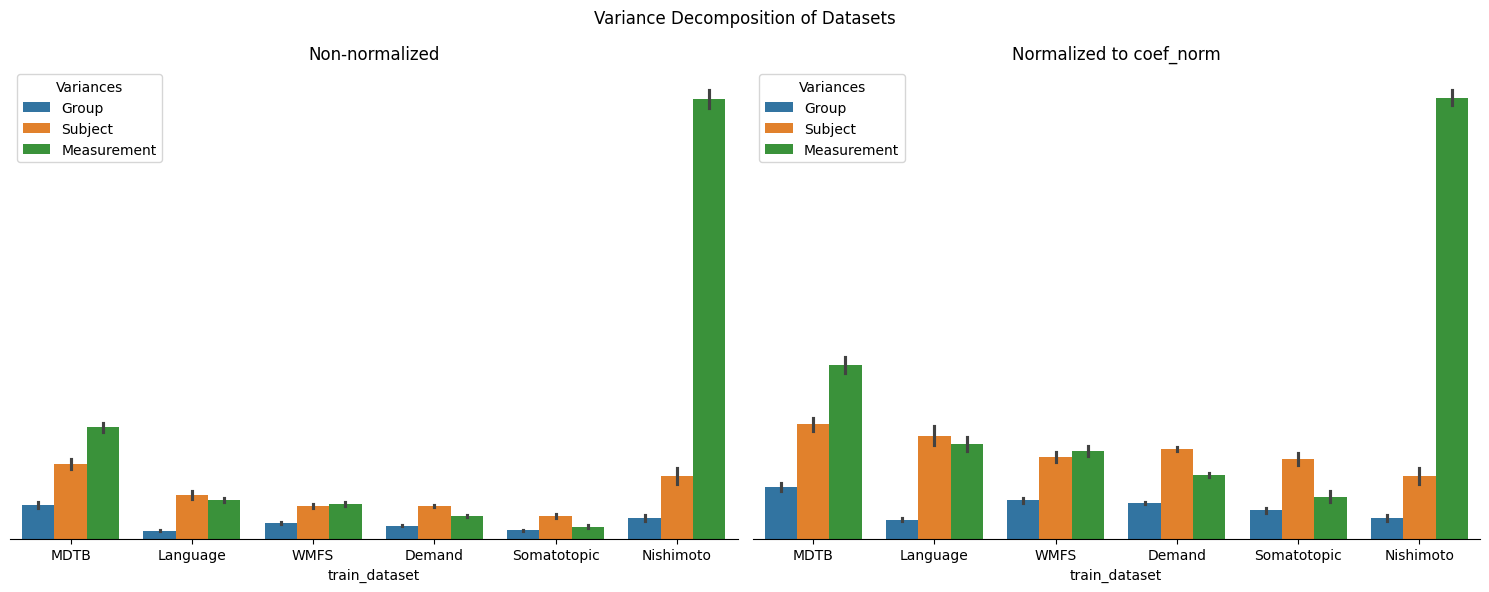

In [ ]:
vars = ['coef_var_g', 'coef_var_s', 'coef_var_m']
decom_df = best_var_df[['train_dataset', 'coef_var_g', 'coef_var_s', 'coef_var_m']].copy()
decom_df['coef_var_m'] /= 2
norm_decom_df = decom_df.copy()
norm_decom_df[['coef_var_g', 'coef_var_s', 'coef_var_m']] = decom_df[['coef_var_g', 'coef_var_s', 'coef_var_m']].div(best_var_df['coef_norm'], axis=0)
decom_df['normalized'] = False
norm_decom_df['normalized'] = True
decom_df = pd.concat([decom_df, norm_decom_df], ignore_index=True)

fig, axes = plt.subplots(1,2,figsize=(15,6))
for i,norm_type in enumerate([False, True]):
    # df_pivot = pd.pivot_table(decom_df[decom_df['normalized']==norm_type], index='train_dataset', values=vars, aggfunc='mean')
    # df_pivot = df_pivot.reindex(dataset_list)
    # df_pivot = df_pivot[vars]
    df_decom_melt = decom_df[decom_df['normalized']==norm_type].melt(id_vars=['train_dataset'], value_vars=vars, var_name='Variances', value_name='value')

    ax = plt.subplot(1,2,i+1)
    sns.barplot(df_decom_melt, x='train_dataset', y='value', hue='Variances', errorbar='se', ax=ax)
    
    # ax = plt.subplot(2,2,i+1)
    # df_pivot.plot(kind='bar', stacked=True, ax=ax)

    if i==0:
        ax.set_title('Non-normalized')
    else:
        ax.set_title('Normalized to coef_norm')
for ax in axes.flatten():
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(handles=handles, labels=['Group', 'Subject', 'Measurement'], title='Variances')
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
plt.suptitle('Variance Decomposition of Datasets')
plt.tight_layout()

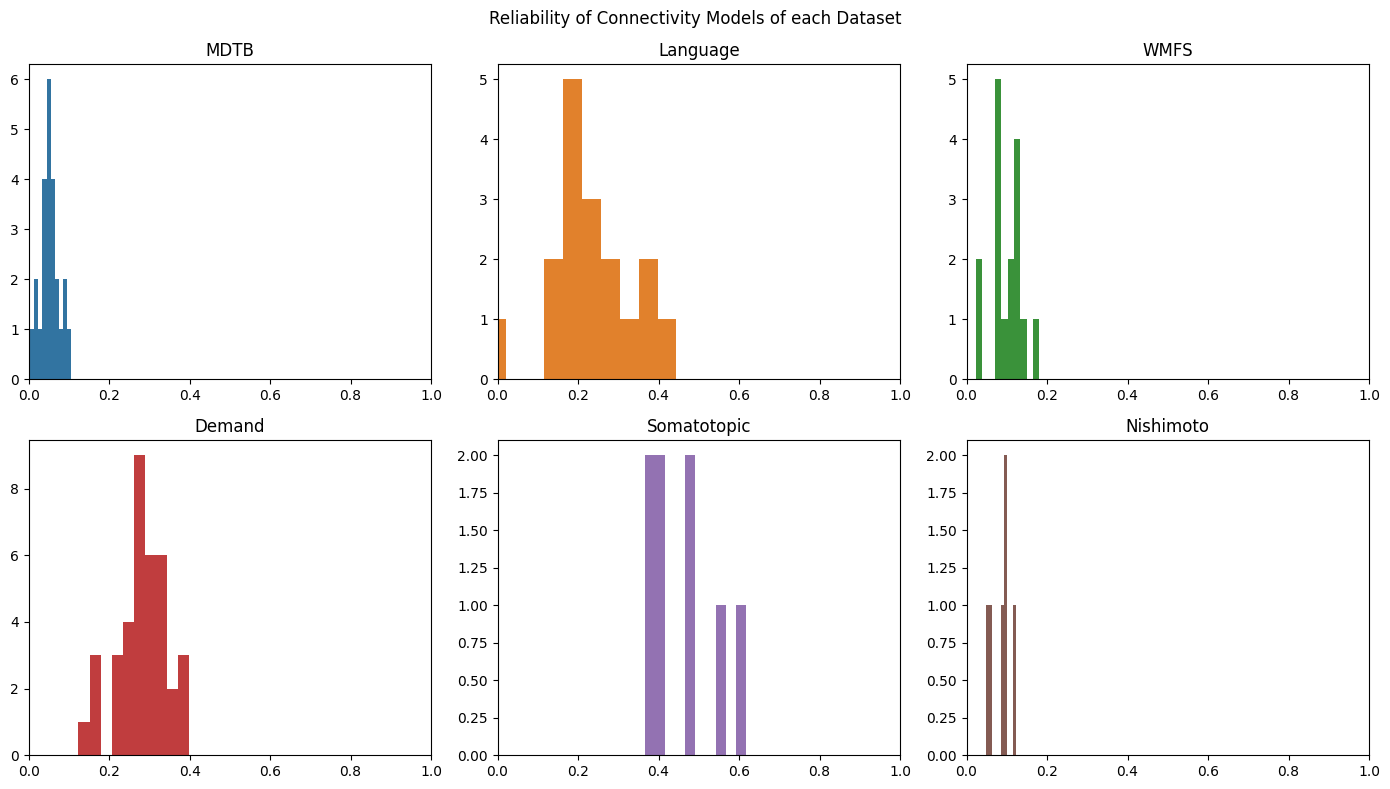

In [39]:
plt.subplots(int(np.ceil(len(dataset_list)/3)),3,figsize=(14,int(np.ceil(len(dataset_list)/3))*4))
plt.suptitle('Reliability of Connectivity Models of each Dataset')
colors = sns.color_palette("tab10", desat=0.75)
for d,dataset in enumerate(dataset_list):
    plt.subplot(int(np.ceil(len(dataset_list)/3)),3,d+1)
    df_to_eval = best_var_df[best_var_df['train_dataset'] == dataset]
    plt.hist(df_to_eval.reliability, color=colors[d])
    plt.legend(f'logalpha={best_var_df['logalpha'][0]}')
    plt.xlim([0, 1])
    plt.title(dataset)
plt.tight_layout()